# UrbanSoundClassification 
I am using the UrbanSound8K dataset for this project.It can be downloaded using the following link ( https://goo.gl/8hY5ER  ). It downloads a compressed tar file of size around 6GB.

In [1]:
import os 
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

In [2]:
df = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv");
print(df.head());

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


In [3]:
print(df.shape);

(8732, 8)


In [4]:
def extractfeatures(filepath):
    y,sr = librosa.load(filepath,sr = None);
    mfcc = librosa.feature.mfcc(y = y,sr = sr,n_mfcc = 40);
    return np.mean(mfcc.T,axis = 0);

In [5]:
x = [];
y = [];
for _,row in tqdm(df.iterrows(),total = len(df)):
    filepath = f"UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}";
    if os.path.exists(filepath):
        features = extractfeatures(filepath);
        x.append(features);
        y.append(row["classID"]);
x = np.array(x);
y = np.array(y);
print(x.shape,y.shape);

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████████████████████████████████████████████████| 8732/8732 [01:20<00:00, 108.74it/s]

(8732, 40) (8732,)


In [6]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.2,random_state = 0);
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape);

(6985, 40) (6985,) (1747, 40) (1747,)


In [7]:
arr = list(set(ytrain));
print(arr);

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1));
xtrain = scaler.fit_transform(xtrain);
xtest = scaler.transform(xtest);

In [9]:
xtrain = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1);
xtest = xtest.reshape(xtest.shape[0],xtest.shape[1],1);
print(xtrain.shape,xtest.shape);

(6985, 40, 1) (1747, 40, 1)


In [10]:
ytrain = tf.keras.utils.to_categorical(ytrain);
ytest = tf.keras.utils.to_categorical(ytest);
print(ytrain.shape,ytest.shape);

(6985, 10) (1747, 10)


In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Flatten,Dense,Dropout
model = Sequential();

In [12]:
model.add(Conv1D(64,kernel_size = 5,activation = "relu",input_shape = (xtrain.shape[1],xtrain.shape[2])));
model.add(MaxPooling1D(2));
model.add(Conv1D(64,kernel_size = 5,activation = "relu"));
model.add(MaxPooling1D(2));
model.add(Flatten());
model.add(Dense(256,activation = "relu"));
model.add(Dropout(0.2));
model.add(Dense(128,activation = "relu"));
model.add(Dropout(0.2));
model.add(Dense(64,activation = "relu"));
model.add(Dense(10,activation = "softmax"));

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer = "adam",loss = "categorical_crossentropy",
metrics = ["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tf.keras.metrics.AUC()]);

In [14]:
history = model.fit(xtrain,ytrain,epochs = 100,batch_size = 128,validation_data = (xtest,ytest));

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1199 - auc: 0.5616 - loss: 2.2747 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1322 - val_auc: 0.6009 - val_loss: 2.2498 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1761 - auc: 0.6308 - loss: 2.2105 - precision: 0.3763 - recall: 7.7530e-04 - val_accuracy: 0.2719 - val_auc: 0.7142 - val_loss: 2.0502 - val_precision: 1.0000 - val_recall: 0.0080
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2923 - auc: 0.7527 - loss: 1.9486 - precision: 0.7724 - recall: 0.0337 - val_accuracy: 0.3921 - val_auc: 0.8195 - val_loss: 1.7162 - val_precision: 0.7252 - val_recall: 0.1254
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4105 - auc: 0.8348 - loss: 1.6618 - precision: 0.7452 - recall: 0.1266 - val_accuracy: 0.4665 - val_auc: 0.8688 - val_loss: 1.4950 - val_precision: 0.7451 - val_recall: 0.2192
Epoch 5/100
55/5

In [15]:
print(model.evaluate(xtest,ytest));

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9034 - auc: 0.9843 - loss: 0.6079 - precision: 0.9050 - recall: 0.9031
[0.44645383954048157, 0.923297107219696, 0.9253302812576294, 0.9221522808074951, 0.9859354496002197]


In [16]:
print(model.summary());

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 36, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,024 (2.03 MB)

 Trainable params: 177,674 (694.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 355,350 (1.36 MB)

None


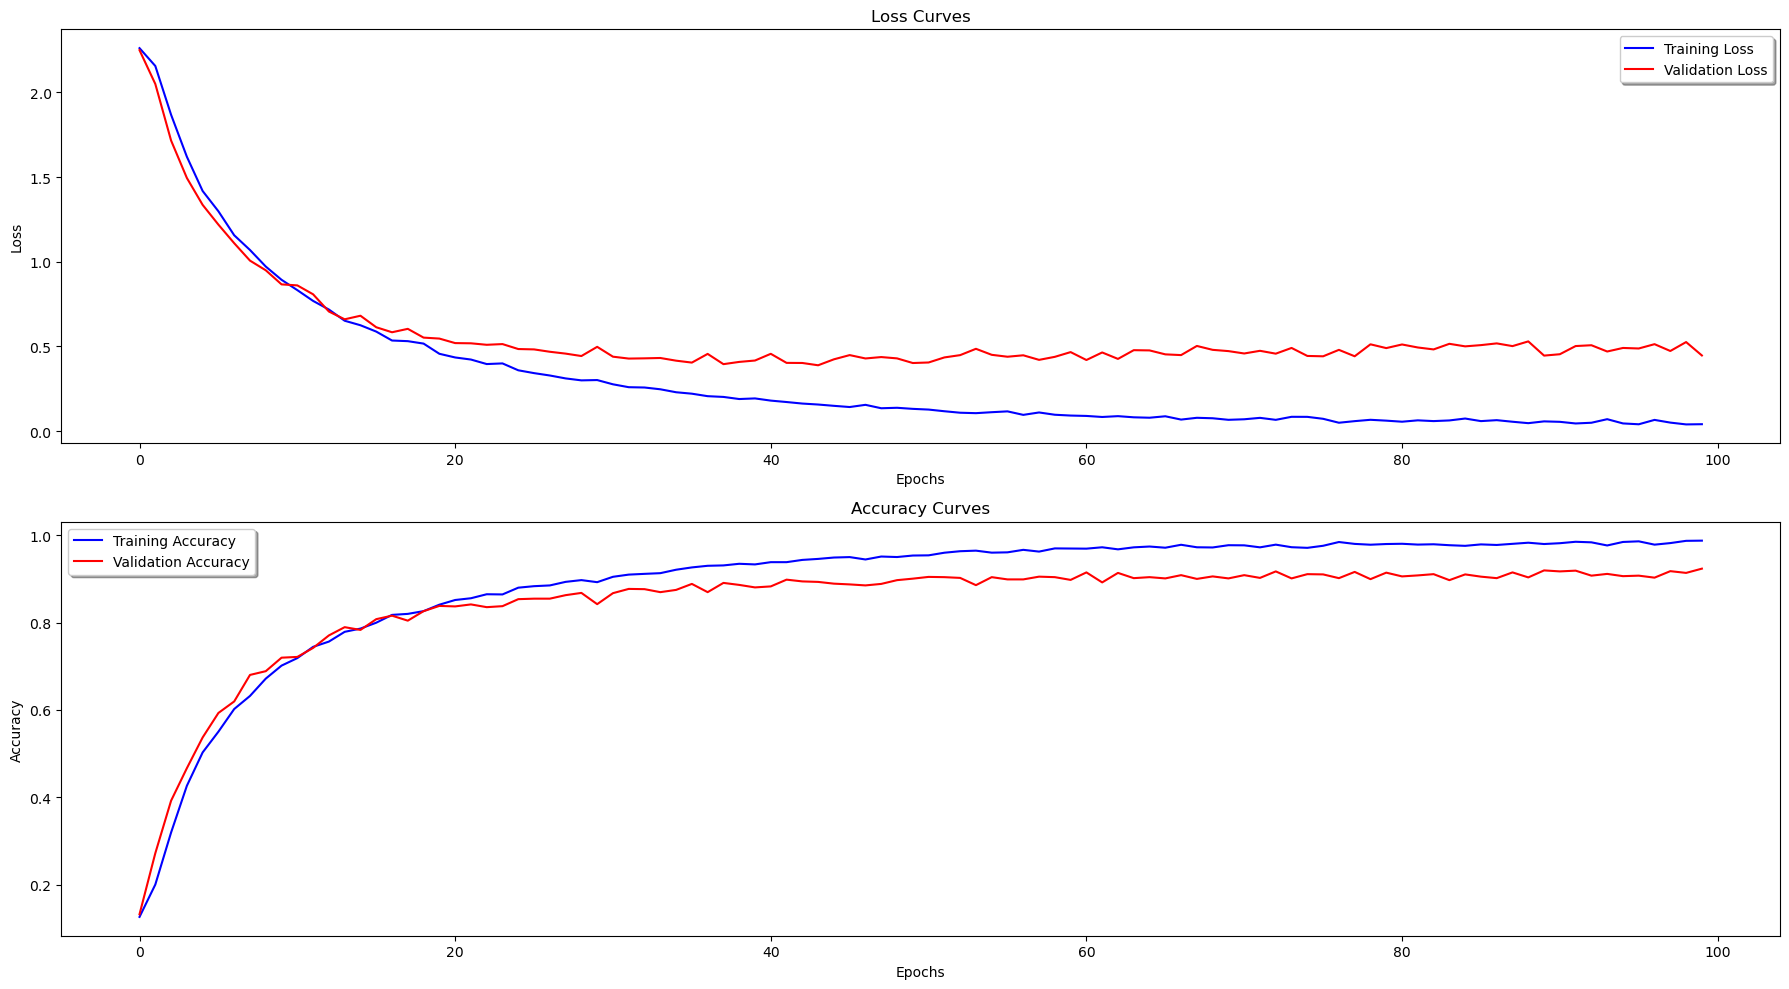

In [17]:
from matplotlib import pyplot as plt
fig,ax = plt.subplots(2,1,figsize = (18,10));
ax[0].plot(history.history["loss"],color = "b",label = "Training Loss");
ax[0].plot(history.history["val_loss"],color = "r",label = "Validation Loss");
ax[0].set_xlabel("Epochs");
ax[0].set_ylabel("Loss");
ax[0].set_title("Loss Curves");
ax[0].legend(loc = "best",shadow = True);
ax[1].plot(history.history["accuracy"],color = "b",label = "Training Accuracy");
ax[1].plot(history.history["val_accuracy"],color = "r",label = "Validation Accuracy");
ax[1].set_xlabel("Epochs");
ax[1].set_ylabel("Accuracy");
ax[1].set_title("Accuracy Curves");
ax[1].legend(loc = "best",shadow = True);
plt.tight_layout();

In [18]:
ypred = model.predict(xtest);
ypred = np.argmax(ypred,axis = 1);
ytest = np.argmax(ytest,axis = 1);
print(ytest.shape,ypred.shape);

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(1747,) (1747,)


In [19]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report;
score = accuracy_score(ytest,ypred);
print(score);

0.9232970807097882


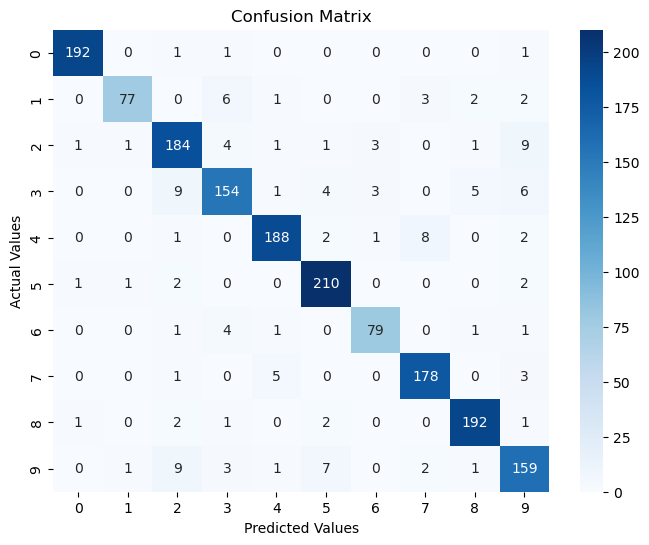

In [20]:
import seaborn as sns 
from matplotlib import pyplot as plt
plt.figure(figsize = (8,6));
cm = confusion_matrix(ytest,ypred);
sns.heatmap(cm,cmap = "Blues",fmt = "d",annot = True,xticklabels = arr,yticklabels = arr);
plt.title("Confusion Matrix");
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");

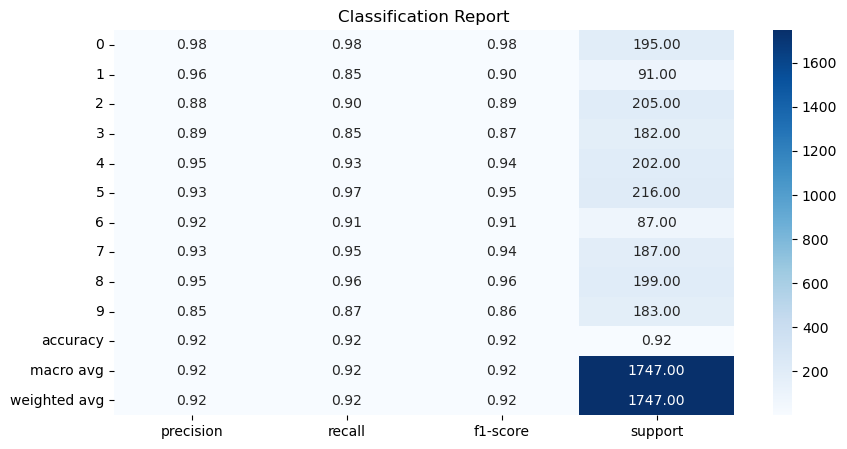

In [21]:
report = classification_report(ytest,ypred,output_dict = True,target_names = arr);
df = pd.DataFrame(report).transpose();
plt.figure(figsize = (10,5));
sns.heatmap(df,fmt = ".2f",annot = True,cmap = "Blues");
plt.title("Classification Report");